# Paststat register - Exercise 3
In this exercise we will take a look at inner joins and left joins with ORM, and learn more about the main tables of PATSTAT Global and PATSTAT register.

## Joins in ORM
We have already seen how to perform joins with ORM in this course with the `.join()` method. These joins are equivalent to inner joins in SQL. Remember that to follow this course it is recommended that you are familiar with the concept of joins in SQL. [This tutorial](https://www.w3schools.com/sql/sql_join.asp) is a good place to get this knowledge.

## PATSTAT global and PATSTAT register
Both databases are centered around a table containing all the applications in each respective database. PATSTAT Register contains only EP applications, while PATSTAT global includes bibliographic data on patent applications from over 100 patent offices. EP applications are therefore present in both databases. 

In [1]:
# Importing the patstat client
from epo.tipdata.patstat import PatstatClient

# Initialize the PATSTAT client
patstat = PatstatClient()

# Access ORM
db = patstat.orm()
# Importing tables as models
from epo.tipdata.patstat.database.models import REG101_APPLN, TLS201_APPLN


## Applications in PATSTAT register
Since all applications in PATSTAT register are EP applications, it follows that to know the amount of EP applications in that database we simply need to query for all applications in the table `REG101_APPLN`.Table `REG101_APPLN` includes a field `appln_auth` that should always show the value `EP`. 

To test this hypothesis, we query table 101 with and without the filter for application authority, and we compare the results.

In [2]:
# Running the query filtering for applications that are Explicitly EP
q = db.query(
    REG101_APPLN.appln_nr.label('application number'),
    REG101_APPLN.appln_id
).filter(
    REG101_APPLN.appln_auth == 'EP'
)

# Getting all applications
r = db.query(
    REG101_APPLN.appln_id
)


# Execute the query and convert the result to a DataFrame
register_applications_ep = patstat.df(q)
total_register_applications = patstat.df(r)
# Display the result
print(f"Register applications with EP as the application authority:{len(register_applications_ep):,}")
print(f"Total register applications:{len(total_register_applications):,}")



Register applications with EP as the application authority:6,778,524
Total register applications:6,778,524


## Applications in PATSTAT global
We can run a similar query in the corresponding table of PATSTAT global. Before we do that, let's see the coverage of application authorities in PATSTAT global.

In [3]:
from sqlalchemy import func  # Import the func module from SQLAlchemy for SQL functions

# Define a query to get the count of applications grouped by application authority
q = db.query(
    func.count(TLS201_APPLN.appln_id).label('applications'),  # Count the number of application IDs and label the result as 'applications'
    TLS201_APPLN.appln_auth.label('authority')  # Get the application authority and label it as 'authority'
).group_by(
    TLS201_APPLN.appln_auth  # Group the results by application authority
).order_by(
    func.count(TLS201_APPLN.appln_id).desc()  # Order the results by the count of applications in descending order
)

# Convert the query result to a DataFrame
distribution = patstat.df(q)

# Display the first 10 rows of the DataFrame
distribution[0:10]


,applications,authority
0,38349201,CN
1,21867386,JP
2,18865932,US
3,7396519,DE
4,5360107,KR
5,4829514,WO
6,4496597,EP
7,3612030,CA
8,3571821,GB
9,3221035,FR


### EP applications in PATSTAT global 
We can see that EP applications are only a relatively small part of the applications contained in PATSTAT global. Let's do a simple query now to compare the number of EP applications in PATSTAT global and in PATSTAT register.

In [4]:
q = db.query( 
TLS201_APPLN.appln_id
).filter(
    TLS201_APPLN.appln_auth == 'EP',
)

# Execute the query and convert the result to a DataFrame
global_applications = patstat.df(q)

# Display the result
print(f"Register:{len(total_register_applications):,}")
print(f"Global:{len(global_applications):,}")

Register:6,778,524
Global:4,496,597


## Inner Joins in ORM
We have already seen inner joins in ORM in this course, since the default join in ORM is an inner join. This means that when the two tables with the condition `REG101_APPLN.appln_id == TLS201_APPLN.appln_id` and we apply the filter `TLS201_APPLN.appln_auth == 'EP'` we will get applications that are
- present in the table REG `REG101_APPLN` **AND**
- present in the table REG `TLS201_APPLN` with application authority EP.

In [9]:
# Join the two tables on the appln_id
q = db.query(
    REG101_APPLN.appln_id,
    TLS201_APPLN.appln_id.label('global_id')
).join(
    TLS201_APPLN, REG101_APPLN.appln_id == TLS201_APPLN.appln_id  # Perform an inner join on appln_id
).filter(
    TLS201_APPLN.appln_auth == 'EP'  # Filter to include only rows where appln_auth is 'EP' in global
)

# Execute the query and convert the result to a DataFrame
joined_applications = patstat.df(q)

# Display the result
print(f"Register:{len(total_register_applications):,}")
print(f"Global:{len(global_applications):,}")
print(f"Inner Join: {len(joined_applications):,}")

Register:6,778,524
Global:4,496,597
Inner Join: 4,314,602


### Visualizing the inner join
We can see in the results above that there are less applications in PATSTAT global than in PATSTAT register, and when we apply the inner join there are even less applications where the ID is in both tables.

Let's create a visual representation of the the coverage of PATSTAT register and PATSTAT global, to better understand the concept of joins. We will use [Mathplotlib](https://matplotlib.org/), which is a library for creating interactive visualizations in Python that comes pre-installed in your TIP workspace, and an [matplotlib_venn](https://pypi.org/project/matplotlib-venn/), a package to create venn diagrams in Mathplotlib. This package is also pre-installed in your workspace. The goal of this course is not to explain these common data visualization libraries, so the code below is only a demonstration of what you can create in TIP once you are familiar with these libraries. 

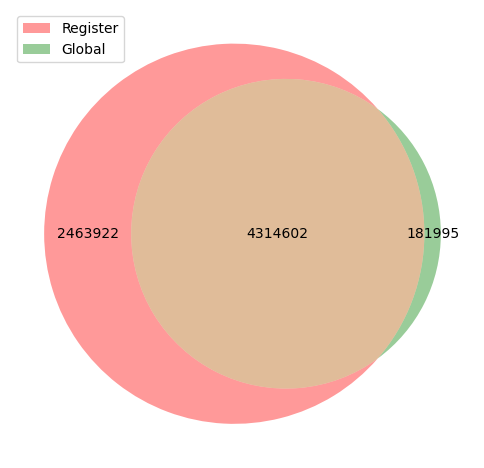

In [6]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2


# Values from the image
register = len(total_register_applications)
global_ = len(global_applications)
inner_join = len(joined_applications)

# Calculate the values for only in Register and only in Global
only_register = register - inner_join
only_global = global_ - inner_join

# Create a Venn diagram
plt.figure(figsize=(6, 6))
venn = venn2(subsets=(only_register, only_global, inner_join), set_labels=('', ''))

# Add a separate legend
plt.legend(['Register', 'Global'], loc='upper left')

# Display the Venn diagram

plt.show()

#### Understanding the venn diagram
The diagram above helps us understand the inner join we just performed. 

- The pink circle is **ALL** the application IDs in the left table, PATSTAT register.
- The green circle is the application IDs in the right table, PATSTAT global, filtered so only those with `EP` as the application authority are present.
- The beige circle is the [inner join](https://www.w3schools.com/sql/sql_join_inner.asp). These are application IDs that are present in both the pink circle and the green circle.

You can see that there is a significant portion of the pink circle not covered by the beige circle. These are application IDs that are in PATSTAT register but do not have a corresponding application ID in PATSTAT global with EP as the application authority. How can this be, if PATSTAT register contains only European patent applications?

To find out we need to continue our data analysis.

### Finding out the applications in register but not in global
We have a dataframe `total_register_applications` that is equivalent to the pink circle, and a dataframe `joined_applications` which is the brown circle. There are several ways to calculate the difference between the two dataframes. In this exercise we are going to use the `isin()` method.

#### What is the `isin()` method?
The isin method in pandas is used to filter data in a DataFrame or Series by checking if each element is present in a list, set, or another Series. It returns a boolean Series that indicates whether each element is present in the provided collection. The syntax for the `isin()` method is

`Series1.isin(series2)`

And returns a boolean for each item in series 1 according to whether it is present in series 2. In this case we want application id column of the `total_register` dataframe as series 1, and column `register_applications` of the `joined applications` dataframe as series 2.

In [10]:
is_in_join = total_register_applications['appln_id'].isin(joined_applications['global_id'])
is_in_join

0           True
1           True
2           True
3           True
4           True
           ...  
6778519    False
6778520    False
6778521    False
6778522    False
6778523    False
Name: appln_id, Length: 6778524, dtype: bool

#### Finding the negative isin
We have now the information of the application IDs in the pink circle that are also in the beige circle. What we need is the opposite, we want `TRUE` if an application ID in the `total_register_applications` is NOT in the `joined_applications`. To get this boolean series we simlpy need to use the negative operator `~`.  We use the negative image of the boolean series 'is_in_join' to filter the `total_register_applications` dataframe and create a new dataframe `difference` that will contain only the application ids in PATSTAT register that are not in the join dataframe, i.e. they do not appear as EP applications in patstat global.

In [11]:
# Find the difference in appln_id between total_register_applications and joined_applications
difference = total_register_applications[~is_in_join]

print(f"Ids in Register:{len(total_register_applications):,}")
print(f"Ids in the inner Join: {len(joined_applications):,}")
print (f"Difference between the two dataframes: {(len(total_register_applications)-len(joined_applications)):,}")
print (f"Lenght of the new difference dataframe:{len(difference):,}")


Ids in Register:6,778,524
Ids in the inner Join: 4,314,602
Difference between the two dataframes: 2,463,922
Lenght of the new difference dataframe:2,463,922


#### What is going on with those applications?
We can see that with the use of `~isin` we seem to have found the applications that are in PATSTAT register but not in PATSTAT global as EP applications. Let's inspect the dataframe to see if it gives us a clue. 

In [12]:
difference.head()

,appln_id
12951,0
12960,0
12976,0
12980,0
12981,0


## Data replenishment in PATSTAT
We can see that all the EP applications that are present in PATSTAT register but not in PATSTAT global have an `application_id` of 0. If you read the [data catalog for PATSTAT global](https://link.epo.org/web/searching-for-patents/business/patstat/data-catalog-patsat-ep-register-spring-en.pdf) you can see that this is indeed expected. 

In the PATSTAT EP Register, an `application_id` value of 0 signifies that the application is a PCT (Patent Cooperation Treaty) international application that has not entered the EP (European Patent) regional phase. These applications mention EP as a designated state but have not proceeded into the European procedure. This means there is no corresponding EP application in the PATSTAT Global database for these entries.

